<a href="https://colab.research.google.com/github/thdgmltjd123/NenepBigData/blob/master/GloVeLSTMsimple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 드라이브와 코랩 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
%matplotlib inline
import copy
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

SEED = 123
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data, datasets
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec

In [5]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bigdata/lemmatizing.csv",index_col = 0)

# **Split Train and Test Data**

In [7]:
review_train, review_test, label_train, label_test = train_test_split(dataset.iloc[:,0],dataset.iloc[:,1], test_size = 0.3, stratify = dataset.iloc[:,1], random_state = 777)

In [8]:
review_train.head()

52602    connect comic source material love god movie e...
72095    happy see justice do childhood favourite story...
84135    bad story nothing enjoyablefighting scene bad ...
15122    almost like watched different movie begin slow...
36430    movie confuse still ask question still many tw...
Name: review, dtype: object

In [10]:
label_train.value_counts()

5    17887
3    17029
7    15872
0    12158
2    11189
8    10582
1     7912
4     6686
6     3375
Name: label, dtype: int64

In [11]:
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

Cuda Status on system is False


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Number of words each review**

In [31]:
li=list(review_train)
tot = []
for review in li:
  temp = review.split()
  tot.append(len(temp))

<function matplotlib.pyplot.show>

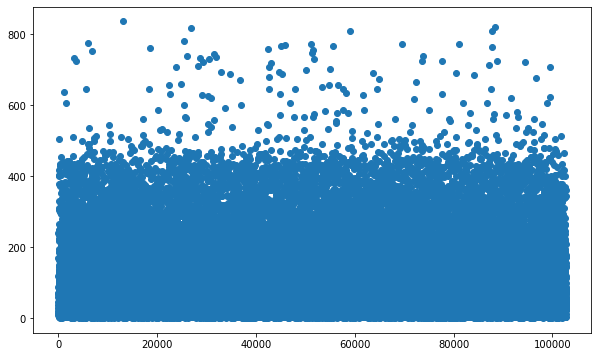

In [37]:
plt.figure(figsize = (10,6))
plt.scatter(range(len(tot)),tot)
plt.show

# **Pre-trained GloVe vectors from Stanford**

In [40]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-12-12 21:42:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-12 21:42:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-12 21:42:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

TypeError: ignored

In [47]:
TEXT = data.Field(sequential=True, batch_first = True, lower = True)
LABEL = data.Field(sequential=False, batch_first= True)

In [46]:
dataset.splits(TEXT,LABEL)

MAX_NB_WORDS = 50000
INPUT_DIM = 300
EMBEDDING_DIM = 200
GloVe_dir = "glove.6B."+str(EMBEDDING_DIM) + "d.txt"

AttributeError: ignored

In [42]:
embeddings_index = {}
f = open(GloVe_dir, encoding = "utf8")
print("Loading GloVe from:", GloVe_dir, '...', end = '')
for line in f:
  values = line.split()
  word = values[0]
  embeddings_index[word] = np.asarray(values[1:], dtype = 'float32')
f.close
print("Done")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
print("All Done")

Loading GloVe from: glove.6B.200d.txt ...Done


NameError: ignored

In [ ]:
#RNN 모델
class RNN(nn.Module):
  def __init__(self, input_size, hidden_dim):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size

    # LSTM Layer
    self.LSTM = nn.Sequential(
        nn.LSTM(
        input_size = input_size,
        hidden_size = hidden_size,
        num_layers = 3,                       # stacked LSTM 3layers
        batch_first = True,               
        bidirectional = True),                # bidirectionalLSTM
        nn.ReLU(),
    )
    # fully-connected Layer
    self.fc1 = nn.Sequential(
        nn.Linear(input_size*2, hidden_size),
        nn.ReLu()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(hidden_size, 9)
    )
    
  def forward(self, x):
    y,_ = self.LSTM(x)
    y = self.fc1(y)
    y = self.fc2(y)
    return y

In [ ]:
epoch = 3
# LSTM using Pytorch
def LSTM(train_loader, test_loader, epoch, learning_rate, no_cuda = False):
  use_cuda = not no_cuda and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  Model = MyModel().to(device)
  optimizer = torch.optim.AdamW(Model.parameters(), lr = learning_rate)
  train_L_iters = []
  train_acc_iters = []
  test_L_iters = []
  test_acc_iters = []
  for i in range(1,epoch+1):
    # Train mode
    train_loss = 0
    train_correct = 0
    Model.train()
    for batch_idx,(data, target) in enumerate(train_loader):
      # data와 target을 gpu를 사용할 수 있게 매핑
      data, target = data.to(device), target.to(device)
      # backward하는 과정에서 기존의 gradient값에 새로운 gradient 값을
      # 더해주기때문에 grad값을 매 backward마다 0으로 초기화해줘야 올바른 학습이 가능
      optimizer.zero_grad()
      # 순전파
      output = Model(data)
      # reduction = (default) "mean"
      loss = F.cross_entropy(output,target)
      train_loss += F.cross_entropy(output,target,reduction = 'sum').item()
      pred = output.argmax(dim = 1, keepdim = True)
      train_correct += pred.eq(target.view_as(pred)).sum().item()
      # 역전파
      loss.backward()
      optimizer.step()
    # 에포크별 평균 트레인 로스 계산
    train_loss /= len(train_loader.dataset)
    train_L_iters.append(train_loss)
    # 에포크별 평균 정확도 계산
    accuracy =  100 * train_correct / len(train_loader.dataset)
    train_acc_iters.append(accuracy)    
    # torch.no_grad() 테스트 할 때, 위에서 계산한 grad를 더이상 업데이트 하지 않음.
    with torch.no_grad():
      Model.eval()
      test_loss = 0
      test_correct = 0
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = Model(data)
        test_loss += F.cross_entropy(output, target, reduction = 'sum').item()
        pred = output.argmax(dim = 1, keepdim = True)
        test_correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_L_iters.append(test_loss)
    accuracy = 100 * test_correct / len(test_loader.dataset)
    test_acc_iters.append(accuracy)
    if i % 20 == 0:
      print("progress = {}, current loss = {}, current device = {}".format(100 * i / epoch, train_loss, torch.cuda.get_device_name()))
      print("test loss = {} test accuracy = {}\n".format(test_loss, accuracy))

  return train_L_iters, train_acc_iters, test_L_iters, test_acc_iters
    